# Introduction

This tutorial will demonstrate how to perform quantile regression using scikit-learn. We will generate two synthetic datasets to illustrate how quantile regression can predict non-trivial conditional quantiles. We will use the **QuantileRegressor** class to estimate the median as well as a low and high quantile fixed at 5% and 95%, respectively. We will compare **QuantileRegressor** with **LinearRegression** and evaluate their performance using mean absolute error (MAE) and mean squared error (MSE).

# Dataset Generation

We will generate two synthetic datasets with the same expected value using a linear relationship with a single feature x. We will add heteroscedastic normal noise and asymmetric Pareto noise to the datasets.

In [1]:
import numpy as np

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]
y_true_mean = 10 + 0.5 * x

# Heteroscedastic Normal noise
y_normal = y_true_mean + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

# Asymmetric Pareto noise
a = 5
y_pareto = y_true_mean + 10 * (rng.pareto(a, size=x.shape[0]) - 1 / (a - 1))

# Dataset Visualization

We will visualize the datasets and the distribution of the residuals **y - mean(y)**.

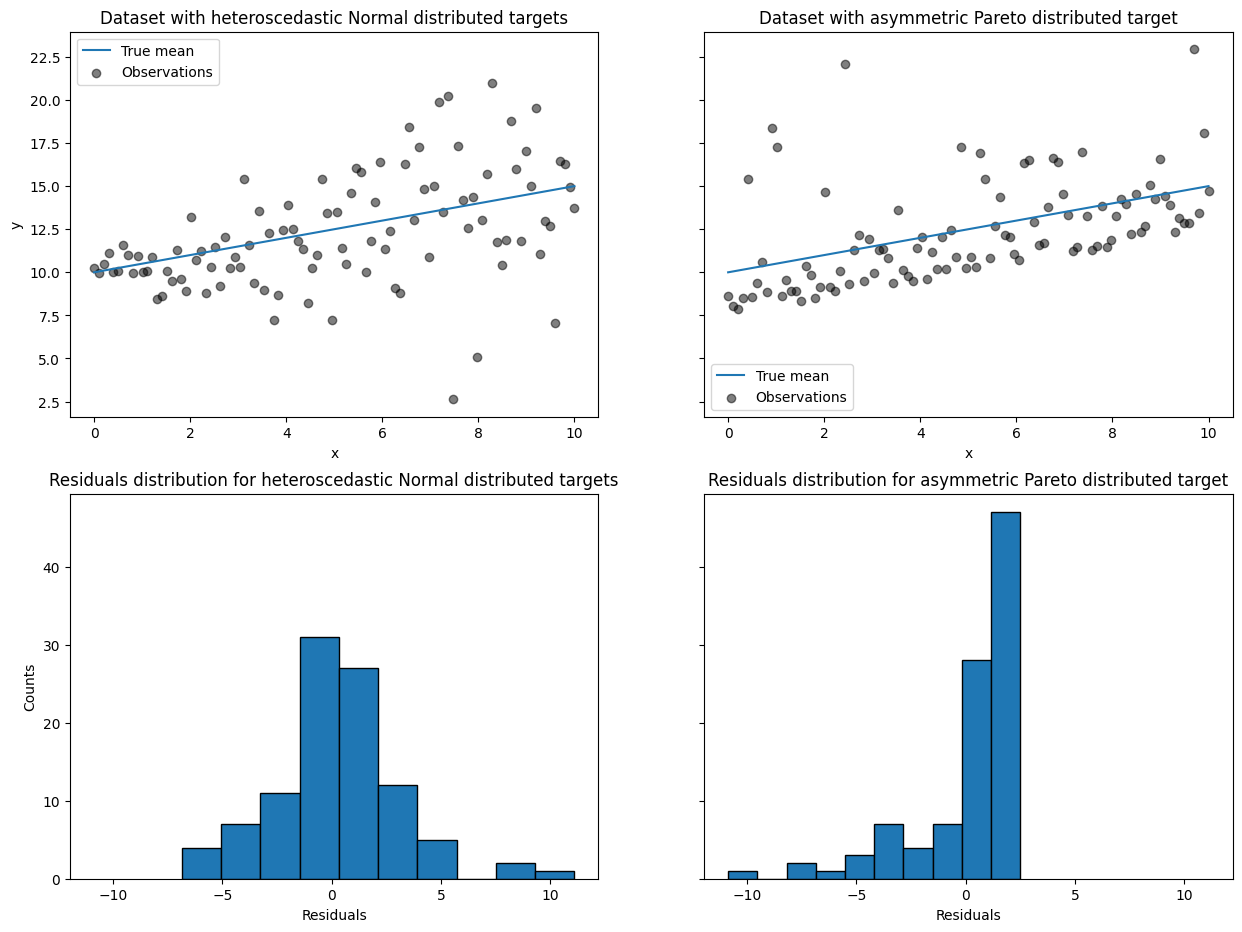

In [2]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 11), sharex="row", sharey="row")

axs[0, 0].plot(x, y_true_mean, label="True mean")
axs[0, 0].scatter(x, y_normal, color="black", alpha=0.5, label="Observations")
axs[1, 0].hist(y_true_mean - y_normal, edgecolor="black")

axs[0, 1].plot(x, y_true_mean, label="True mean")
axs[0, 1].scatter(x, y_pareto, color="black", alpha=0.5, label="Observations")
axs[1, 1].hist(y_true_mean - y_pareto, edgecolor="black")

axs[0, 0].set_title("Dataset with heteroscedastic Normal distributed targets")
axs[0, 1].set_title("Dataset with asymmetric Pareto distributed target")
axs[1, 0].set_title(
    "Residuals distribution for heteroscedastic Normal distributed targets"
)
axs[1, 1].set_title("Residuals distribution for asymmetric Pareto distributed target")
axs[0, 0].legend()
axs[0, 1].legend()
axs[0, 0].set_ylabel("y")
axs[1, 0].set_ylabel("Counts")
axs[0, 1].set_xlabel("x")
axs[0, 0].set_xlabel("x")
axs[1, 0].set_xlabel("Residuals")
_ = axs[1, 1].set_xlabel("Residuals")

With the heteroscedastic Normal distributed target, we observe that the variance of the noise is increasing when the value of the feature x is increasing.

With the asymmetric Pareto distributed target, we observe that the positive residuals are bounded.

These types of noisy targets make the estimation via **LinearRegression** less efficient, i.e. we need more data to get stable results and, in addition, large outliers can have a huge impact on the fitted coefficients. (Stated otherwise: in a setting with constant variance, ordinary least squares estimators converge much faster to the true coefficients with increasing sample size.)

In this asymmetric setting, the median or different quantiles give additional insights. On top of that, median estimation is much more robust to outliers and heavy tailed distributions. But note that extreme quantiles are estimated by very few data points. 95% quantile are more or less estimated by the 5% largest values and thus also a bit sensitive outliers.

In the remainder of this tutorial, we will show how **QuantileRegressor** can be used in practice and give the intuition into the properties of the fitted models. Finally, we will compare the both **QuantileRegressor** and LinearRegression.

# Fitting a QuantileRegressor

In this section, we want to estimate the conditional median as well as a low and high quantile fixed at 5% and 95%, respectively. Thus, we will get three linear models, one for each quantile.

We will use the quantiles at 5% and 95% to find the outliers in the training sample beyond the central 90% interval.

In [4]:
from sklearn.linear_model import QuantileRegressor

quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_normal).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_normal
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_normal
        )

Now, we can plot the three linear models and the distinguished samples that are within the central 90% interval from samples that are outside this interval.

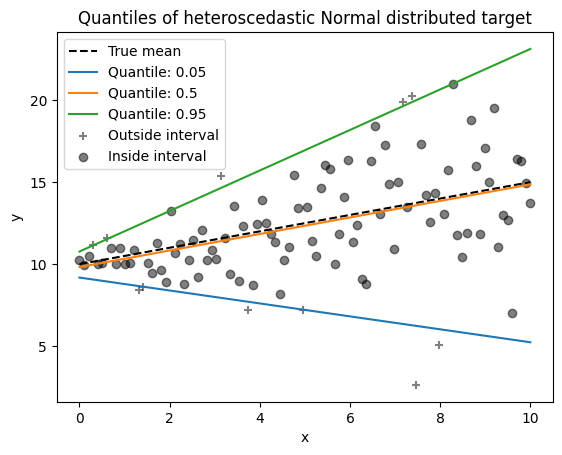

In [5]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_normal[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_normal[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of heteroscedastic Normal distributed target")

Since the noise is still Normally distributed, in particular is symmetric, the true conditional mean and the true conditional median coincide. Indeed, we see that the estimated median almost hits the true mean. We observe the effect of having an increasing noise variance on the 5% and 95% quantiles: the slopes of those quantiles are very different and the interval between them becomes wider with increasing x.

To get an additional intuition regarding the meaning of the 5% and 95% quantiles estimators, one can count the number of samples above and below the predicted quantiles (represented by a cross on the above plot), considering that we have a total of 100 samples.

We can repeat the same experiment using the asymmetric Pareto distributed target.

In [6]:
quantiles = [0.05, 0.5, 0.95]
predictions = {}
out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    y_pred = qr.fit(X, y_pareto).predict(X)
    predictions[quantile] = y_pred

    if quantile == min(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred >= y_pareto
        )
    elif quantile == max(quantiles):
        out_bounds_predictions = np.logical_or(
            out_bounds_predictions, y_pred <= y_pareto
        )

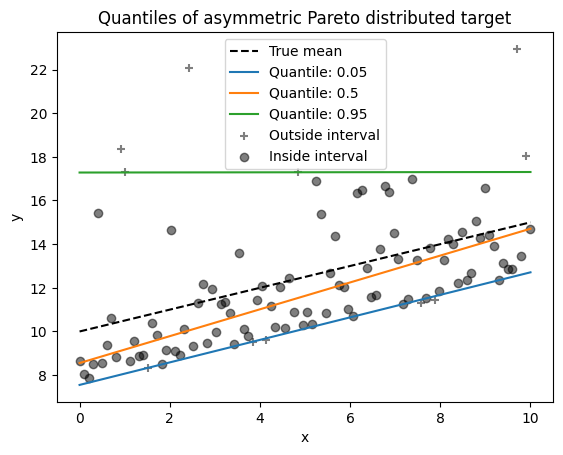

In [7]:
plt.plot(X, y_true_mean, color="black", linestyle="dashed", label="True mean")

for quantile, y_pred in predictions.items():
    plt.plot(X, y_pred, label=f"Quantile: {quantile}")

plt.scatter(
    x[out_bounds_predictions],
    y_pareto[out_bounds_predictions],
    color="black",
    marker="+",
    alpha=0.5,
    label="Outside interval",
)
plt.scatter(
    x[~out_bounds_predictions],
    y_pareto[~out_bounds_predictions],
    color="black",
    alpha=0.5,
    label="Inside interval",
)

plt.legend()
plt.xlabel("x")
plt.ylabel("y")
_ = plt.title("Quantiles of asymmetric Pareto distributed target")

Due to the asymmetry of the distribution of the noise, we observe that the true mean and estimated conditional median are different. We also observe that each quantile model has different parameters to better fit the desired quantile. Note that ideally, all quantiles would be parallel in this case, which would become more visible with more data points or less extreme quantiles, e.g. 10% and 90%.

# Comparing QuantileRegressor and LinearRegression

In this section, we will linger on the difference regarding the loss functions that **QuantileRegressor** and **LinearRegression** are minimizing.

Indeed, **LinearRegression** is a least squares approach minimizing the mean squared error (MSE) between the training and predicted targets. In contrast, **QuantileRegressor** with quantile=0.5 minimizes the mean absolute error (MAE) instead.

Let’s compute the training errors of such models in terms of mean squared error and mean absolute error. We will use the asymmetric Pareto distributed target to make it more interesting as mean and median are not equal.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

linear_regression = LinearRegression()
quantile_regression = QuantileRegressor(quantile=0.5, alpha=0)

y_pred_lr = linear_regression.fit(X, y_pareto).predict(X)
y_pred_qr = quantile_regression.fit(X, y_pareto).predict(X)

print(
    "Training error (in-sample performance)\n"
    f"{'model':<20}   MAE   MSE\n"
    f"{linear_regression.__class__.__name__:<20} "
    f"{mean_absolute_error(y_pareto, y_pred_lr):5.3f} "
    f"{mean_squared_error(y_pareto, y_pred_lr):5.3f}\n"
    f"{quantile_regression.__class__.__name__:<20} "
    f"{mean_absolute_error(y_pareto, y_pred_qr):5.3f} "
    f"{mean_squared_error(y_pareto, y_pred_qr):5.3f}"
)

Training error (in-sample performance)
model                  MAE   MSE
LinearRegression     1.805 6.486
QuantileRegressor    1.670 7.025


On the training set, we see that MAE is lower for QuantileRegressor than LinearRegression. In contrast to that, MSE is lower for LinearRegression than QuantileRegressor. These results confirms that MAE is the loss minimized by QuantileRegressor while MSE is the loss minimized LinearRegression.

We can make a similar evaluation by looking at the test error obtained by cross-validation.

In [9]:
from sklearn.model_selection import cross_validate

cv_results_lr = cross_validate(
    linear_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
cv_results_qr = cross_validate(
    quantile_regression,
    X,
    y_pareto,
    cv=3,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error"],
)
print(
    "Test error (cross-validated performance)\n"
    f"{'model':<20}   MAE   MSE\n"
    f"{linear_regression.__class__.__name__:<20} "
    f"{-cv_results_lr['test_neg_mean_absolute_error'].mean():5.3f} "
    f"{-cv_results_lr['test_neg_mean_squared_error'].mean():5.3f}\n"
    f"{quantile_regression.__class__.__name__:<20} "
    f"{-cv_results_qr['test_neg_mean_absolute_error'].mean():5.3f} "
    f"{-cv_results_qr['test_neg_mean_squared_error'].mean():5.3f}"
)

Test error (cross-validated performance)
model                  MAE   MSE
LinearRegression     1.732 6.690
QuantileRegressor    1.679 7.129


# Summary

In this tutorial, we learned how to perform quantile regression using scikit-learn. We generated two synthetic datasets to illustrate how quantile regression can predict non-trivial conditional quantiles. We used the **QuantileRegressor** class to estimate the median as well as a low and high quantile fixed at 5% and 95%, respectively. We compared **QuantileRegressor** with **LinearRegression** and evaluated their performance using mean absolute error (MAE) and mean squared error (MSE).